# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

## Prerequisites
- Basic Matplotlib skills for plotting 2-D data clearly.
- Basic understanding of Pandas and how to use it for data manipulation.
- The concepts behind clustering algorithms, although we will go through this throughout the project.

## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength / Performance Metric

[**Task 4**](#task4): K-Means Clustering

[**Task 5**](#task5): DBSCAN

[**Task 6**](#task6): HDBSCAN

[**Task 7**](#task7): Addressing Outliers

[**Further Reading**](#further)

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [203]:
df = pd.read_csv('anaconda3/taxi_data.csv')

In [204]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive


from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

In [205]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [206]:
df.duplicated(subset=['LON','LAT']).values.any()
#To find if there are any duplicates

True

In [207]:
df.isna().values.any()


True

In [208]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON','LAT'],keep='first',inplace=True)


print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [209]:
df.isna().values.any()

False

In [210]:
df.duplicated(subset=['LON','LAT']).values.any()
#To find if there are any duplicates

False

In [211]:
X=np.array(df[['LON','LAT']],dtype='float64')

In [212]:
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

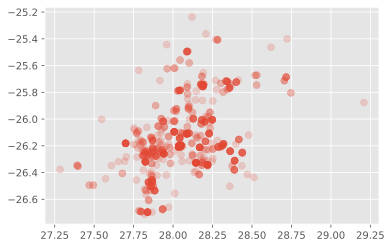

In [213]:
plt.scatter(X[:,0],X[:,1],s=50,alpha=0.2)
#s- marker size
#alpha- blending value, between 0 (transparent) and 1 (opaque)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [214]:
m= folium.Map(location=[df.LAT.mean(),df.LON.mean()],zoom_start=9,tiles='Stamen Toner')
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT,row.LON],
        radius=5,
         popup=re.sub(r'[^a-zA-Z ]+','',row.NAME),       
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
    

In [215]:
print(df.LAT.mean(),df.LON.mean())


-26.145015309842083 28.06590763061967


In [216]:
m

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

In [217]:
X_blobs, _=make_blobs(n_samples=1000, centers=10,n_features=2,cluster_std=0.5,
                       random_state=4)
# The make_blobs() function can be used to generate blobs of points with a Gaussian distribution. It generate isotropic Gaussian blobs for clustering.

In [218]:
print(X_blobs)
len(X_blobs)

[[ -6.89867307   2.31150542]
 [ -9.73185423  -2.9970871 ]
 [ -5.37043025  -1.50923072]
 ...
 [  9.30620243  -9.77320382]
 [  4.15014679  -5.17853902]
 [-10.32190081  -1.37670435]]


1000

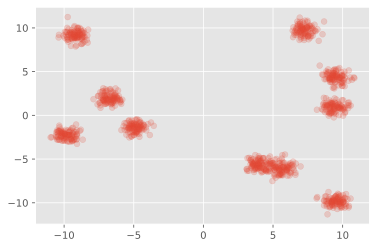

In [219]:
plt.scatter(X_blobs[:,0],X_blobs[:,1],alpha=0.2)

In [220]:
class_predictions= np.load('anaconda3/sample_clusters.npy')
# sample_cluster is a binary file to store sample cluster numpy arrays

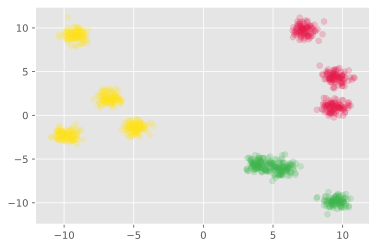

In [222]:
unique_clusters=np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X=X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0],X[:,1],alpha=0.2,c=cols[unique_cluster] )

In [223]:
#The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
#The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

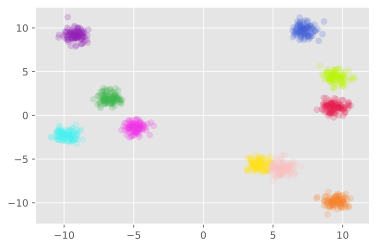

In [224]:
class_predictions= np.load('anaconda3/sample_clusters_improved.npy')
unique_clusters=np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X=X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0],X[:,1],alpha=0.2 ,c=cols[unique_cluster])

In [225]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

<a id='task4'></a>
# Task 4: K-Means Clustering

In [226]:

X_blobs, _ = make_blobs(n_samples=1000, centers=50 , 
                        n_features=2, cluster_std=1, random_state=4)


In [227]:
X_blobs

array([[-6.55430235,  2.75889697],
       [-2.35940277,  6.08803659],
       [-2.71177954,  3.23383474],
       ...,
       [ 3.32071835, -6.04881228],
       [ 0.56112708, -6.58320351],
       [ 6.78002346, -7.24136057]])

In [228]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [230]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [231]:
X=np.array(df[['LON','LAT']],dtype='float64')
k=70
model=KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions= model.predict(X)
df['CLUSTER_kmeans(k)']= class_predictions
df.to_csv('result.csv')


In [232]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans(k)
0  28.17858 -25.73882         11th Street Taxi Rank                 15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                 15
2  27.83239 -26.53722          Adams Road Taxi Rank                  5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                 33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                 18

In [233]:
def create_map(df,cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

      
        cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'],row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m


m = create_map(df,'CLUSTER_kmeans(k)')  
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')
m

K=70
Silhouette Score: 0.6367300948588169


In [234]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████████████████████████████████████| 98/98 [00:58<00:00,  1.68it/s]

K=98
Silhouette Score: 0.6971995093259049


<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise 

In [235]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new =np.array([(counter+2)*x if x==-1 else x  for counter , x in enumerate(dummy)])
new

array([-2, -3, -4,  2,  3,  4,  5, -9])

In [236]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions=model.labels_
df['CLUSTERS_DBSCAN']=class_predictions
df

LON       LAT                          NAME  CLUSTER_kmeans(k)  \
0    28.17858 -25.73882         11th Street Taxi Rank                 15   
1    28.17660 -25.73795    81 Bazaar Street Taxi Rank                 15   
2    27.83239 -26.53722          Adams Road Taxi Rank                  5   
3    28.12514 -26.26666  Alberton City Mall Taxi Rank                 33   
4    28.10144 -26.10567      Alexandra Main Taxi Rank                 18   
..        ...       ...                           ...                ...   
832  28.04441 -26.19727            Zimbabwe Taxi Rank                  7   
833  27.82999 -26.24445         Zola Clinic Taxi Rank                  1   
834  27.83991 -26.24235                Zola Taxi Rank                  1   
835  27.86166 -26.23624               Zondi Taxi Rank                 49   
836  28.39097 -26.30931            kwaThema Taxi Rank                 10   

     CLUSTERS_DBSCAN  
0                  0  
1                  0  
2                 -1  
3                 -1  
4                  1  
..               ...  
832                9  
833               25  
834               -1  
835               -1  
836               19  

[823 rows x 5 columns]

In [237]:
m=create_map(df, 'CLUSTERS_DBSCAN')
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
#Outliers are the data points those cannot be fitted in any type of clusters.
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')
print(f'Silhoutte ignoring outliers: {silhouette_score(X[class_predictions!=-1],class_predictions[class_predictions!=-1])}')
no_outliers=0
no_outliers=np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhoutte outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhoutte ignoring outliers: 0.9232138245464832
Silhoutte outliers as singletons: 0.5667489347788776


In [238]:
m

<a id='task6'></a>
# Task 6: HDBSCAN
Hierarchical DBSCAN

In [239]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)
class_predictions= model.fit_predict(X)
df['CLUSTER_HDBSCAN']=class_predictions
df

LON       LAT                          NAME  CLUSTER_kmeans(k)  \
0    28.17858 -25.73882         11th Street Taxi Rank                 15   
1    28.17660 -25.73795    81 Bazaar Street Taxi Rank                 15   
2    27.83239 -26.53722          Adams Road Taxi Rank                  5   
3    28.12514 -26.26666  Alberton City Mall Taxi Rank                 33   
4    28.10144 -26.10567      Alexandra Main Taxi Rank                 18   
..        ...       ...                           ...                ...   
832  28.04441 -26.19727            Zimbabwe Taxi Rank                  7   
833  27.82999 -26.24445         Zola Clinic Taxi Rank                  1   
834  27.83991 -26.24235                Zola Taxi Rank                  1   
835  27.86166 -26.23624               Zondi Taxi Rank                 49   
836  28.39097 -26.30931            kwaThema Taxi Rank                 10   

     CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  
0                  0               19  
1                  0               19  
2                 -1               -1  
3                 -1               -1  
4                  1               55  
..               ...              ...  
832                9               53  
833               25               63  
834               -1               63  
835               -1               65  
836               19               14  

[823 rows x 6 columns]

In [240]:
m=create_map(df,'CLUSTER_HDBSCAN')
print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')
m


Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504353546712
Silhouette outliers as singletons: 0.6389924830256725


In [ ]:
# hdbscan.HDBSCAN?

<a id='task7'></a>
# Task 7: Addressing Outliers


In [243]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier

KNeighborsClassifier(n_neighbors=1)

In [254]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict=df[df.CLUSTER_HDBSCAN==-1]


In [257]:
x_train= np.array(df_train[['LON','LAT']],dtype='float64')
y_train= np.array(df_train['CLUSTER_HDBSCAN'])
x_predict= np.array(df_predict[['LON','LAT']],dtype='float64')

In [258]:
classifier.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [259]:
predictions =classifier.predict(x_predict)
predictions

array([26, 41, 13, 44, 57, 26, 34,  4, 60, 60, 16, 16, 61, 24, 51, 51, 51,
       58, 41, 63, 13, 45, 15, 45, 45,  6,  0, 17, 26, 26, 26, 49, 49, 53,
       49, 13, 61, 26, 26, 39, 65, 31, 31, 31,  0, 46, 46, 21, 58, 60,  6,
        5, 24,  1, 63, 34, 64, 36, 36, 16,  7,  3, 64, 41, 13, 39, 39, 39,
       41, 40, 40, 25, 59, 57, 61, 61, 62, 26, 15, 15, 59, 63,  6, 19, 61,
       61, 48,  4, 41, 21, 64, 64, 64, 61, 61, 21, 23, 38, 31, 41, 55, 55],
      dtype=int64)

In [260]:
df['CLUSTER_hybrid']=df['CLUSTER_HDBSCAN']
df

LON       LAT                          NAME  CLUSTER_kmeans(k)  \
0    28.17858 -25.73882         11th Street Taxi Rank                 15   
1    28.17660 -25.73795    81 Bazaar Street Taxi Rank                 15   
2    27.83239 -26.53722          Adams Road Taxi Rank                  5   
3    28.12514 -26.26666  Alberton City Mall Taxi Rank                 33   
4    28.10144 -26.10567      Alexandra Main Taxi Rank                 18   
..        ...       ...                           ...                ...   
832  28.04441 -26.19727            Zimbabwe Taxi Rank                  7   
833  27.82999 -26.24445         Zola Clinic Taxi Rank                  1   
834  27.83991 -26.24235                Zola Taxi Rank                  1   
835  27.86166 -26.23624               Zondi Taxi Rank                 49   
836  28.39097 -26.30931            kwaThema Taxi Rank                 10   

     CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  
0                  0               19              19  
1                  0               19              19  
2                 -1               -1              -1  
3                 -1               -1              -1  
4                  1               55              55  
..               ...              ...             ...  
832                9               53              53  
833               25               63              63  
834               -1               63              63  
835               -1               65              65  
836               19               14              14  

[823 rows x 7 columns]

In [264]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid']= predictions

In [266]:
m=create_map(df, 'CLUSTER_hybrid')
m

In [267]:
class_predictions=df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126491937117


Text(0.5, 0, 'cluster ')

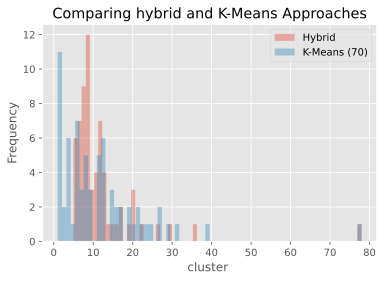

In [275]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70,alpha=0.4,label='Hybrid')
df['CLUSTER_kmeans(k)'].value_counts().plot.hist(bins=70,alpha=0.4,label='K-Means (70)')
plt.legend()
plt.title('Comparing hybrid and K-Means Approaches')
plt.xlabel('cluster ')

### This concludes that the prediction is nearly similar to K-Means